In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns

In [13]:
df_projects = pd.read_csv('data/projectList.csv')

#Drop Title, ArticleURL columns. They are from the original article and are not needed
# Drop unnecessary columns
columns_to_drop = [ 'Family', 'Language', 'glottocode', 'isocode', 'Speakers']
df_projects.drop(columns_to_drop, axis=1, inplace=True)
# Delete duplicates from the dataset. As we have dropped the language related columns, we will consider the project name and the country as discerning factors
df_projects.drop_duplicates(inplace=True)
print("We begin the analysis with {} projects".format(df_projects.shape[0]))

We begin the analysis with 439 projects


We mark any project that is involved with social media or technology as digital

In [14]:
df_projects['Digital'] = df_projects['Social media'] + df_projects['Technology']
df_projects['Digital'] = df_projects['Digital'].apply(lambda x: 1 if x > 0 else 0)

df_projects['NonDigital'] = df_projects['Digital'].apply(lambda x: 0 if x == 1 else 1)

df_projects = df_projects[['Year', 'Project', 'Digital', 'NonDigital']]

In [16]:
total_proyectos = df_projects.groupby('Year').size()

num_proyectos_year = df_projects.groupby('Year')[['Digital', 'NonDigital']].sum()
# num_proyectos_year.to_csv('Num_digital_proyectos_year.csv')

Same as in the other notebook, we do not consider the last 2 years of data as they are incomplete.

In [17]:
if True:
    i=-2
    df_num_proyectos=num_proyectos_year[:i]

We will model the data using a generalized linear model using the 5 year rolling mean approach.

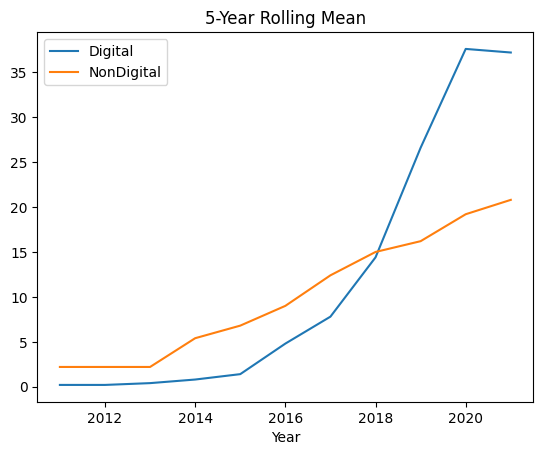

In [18]:
df_mean_5 = df_num_proyectos.rolling(5).mean().dropna()
df_mean_5.plot()
plt.title('5-Year Rolling Mean')
plt.show()

In [19]:
df_mean_expanded = pd.DataFrame(columns=['Year', 'Category', 'Value'])
for year in df_mean_5.index:
    for column in df_mean_5.columns[:3]:
        df_mean_expanded.loc[len(df_mean_expanded)] = [year, column, df_mean_5.loc[year, column]]

# Initial Model

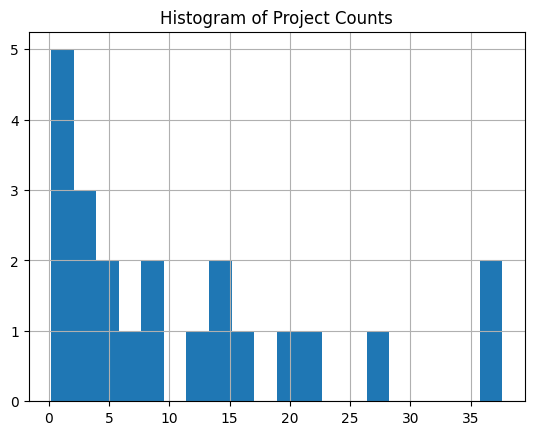

In [20]:
df_mean_expanded['Value'].hist(bins=20)
plt.title('Histogram of Project Counts')
plt.show()

In [21]:
df_num_proyectos_by_year = pd.DataFrame(columns=['Year', 'Value'])
for year in df_num_proyectos.index:
    df_num_proyectos_by_year.loc[len(df_num_proyectos_by_year)] = [year, df_num_proyectos.loc[year].sum()]

In [22]:
poisson_glm = smf.glm('Value ~ Year + Category', data=df_mean_expanded, family=sm.families.Poisson()).fit()
print(poisson_glm.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Value   No. Observations:                   22
Model:                            GLM   Df Residuals:                       19
Model Family:                 Poisson   Df Model:                            2
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -55.807
Date:                Fri, 07 Jun 2024   Deviance:                       33.809
Time:                        10:26:58   Pearson chi2:                     30.2
No. Iterations:                     5   Pseudo R-squ. (CS):             0.9999
Covariance Type:            nonrobust                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               -676

In [23]:
#Probamos equidispersion
print('Variance:',df_mean_expanded['Value'].var())
print('Mean:',df_mean_expanded['Value'].mean())
print('Variance/Mean:',df_mean_expanded['Value'].var()/df_mean_expanded['Value'].mean())

Variance: 130.14337662337664
Mean: 11.036363636363637
Variance/Mean: 11.792233466698047


To treat overdispersion we will use a negative binomial regression. We first calculate the alpha parameter to use

In [24]:
df_mean_expanded['Lambda'] = poisson_glm.mu
df_mean_expanded['AUX_OLS'] = df_mean_expanded.apply(lambda x: ((x['Value'] - x['Lambda'])**2 - x['Lambda']) / x['Lambda'], axis=1)
ols_expr = """AUX_OLS ~ Lambda - 1"""
aux_olsr_results = smf.ols(ols_expr, df_mean_expanded).fit()
print(aux_olsr_results.params)  

Lambda    0.029721
dtype: float64


In [25]:
print(aux_olsr_results.tvalues)
print(poisson_glm.df_resid)

#T-Value (right-tailed): 1.669402
degrees_of_freedom = poisson_glm.df_resid
from scipy.stats import t
alpha = 0.05
t_to_compare=t.ppf(1-alpha, degrees_of_freedom)

if aux_olsr_results.tvalues[0] > t_to_compare:
    print('The alpha parameter is significant')
else:
    print('The alpha parameter is not significant')

alpha = aux_olsr_results.params[0]

Lambda    1.873072
dtype: float64
19
The alpha parameter is significant


# Negative Binomial Model

In [28]:
alpha=aux_olsr_results.params[0]
nbinomial_glm = smf.glm('Value ~ Year + Category', data=df_mean_expanded, family=sm.families.NegativeBinomial(alpha=alpha)).fit()
print(nbinomial_glm.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Value   No. Observations:                   22
Model:                            GLM   Df Residuals:                       19
Model Family:        NegativeBinomial   Df Model:                            2
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -54.646
Date:                Fri, 07 Jun 2024   Deviance:                       25.833
Time:                        10:27:43   Pearson chi2:                     22.7
No. Iterations:                     7   Pseudo R-squ. (CS):             0.9992
Covariance Type:            nonrobust                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               -698

In [29]:
# Calculate Pearson's chi-squared statistic
from scipy import stats


pearson_chi2 = np.sum(nbinomial_glm.resid_pearson**2)

# Calculate degrees of freedom
df = len(nbinomial_glm.resid_pearson) - len(nbinomial_glm.params)

# Calculate dispersion ratio
dispersion_ratio = pearson_chi2 / df

# Calculate p-value
p_value = 1 - stats.chi2.cdf(pearson_chi2, df)

# Print results
print('Overdispersion test\n')
print('dispersion ratio =', dispersion_ratio)
print("Pearson's Chi-Squared =", pearson_chi2)
print('p-value =', p_value)

# Check for overdispersion
if p_value < 0.05:
    print('Model is overdispersed')
else:
    print('Model is not overdispersed')

Overdispersion test

dispersion ratio = 1.1950594972746789
Pearson's Chi-Squared = 22.7061304482189
p-value = 0.2505336191878499
Model is not overdispersed


Naïve RMSE as a base. We predict the mean of the data and calculate the RMSE.

In [30]:
from sklearn.metrics import mean_squared_error

df_naive_mean = df_mean_5.copy()

for column in df_num_proyectos.columns:
    df_naive_mean[column] = df_naive_mean[column].mean()

    # Get the actual and forecasted values
    actual = df_mean_5[column].values
    naive_mean = df_naive_mean[column].values
    
    # Calculate and print the RMSE
    rmse = sqrt(mean_squared_error(actual, naive_mean))
    print(f'Naive RMSE for {column}: {rmse}')

Naive RMSE for Digital: 14.236978971956583
Naive RMSE for NonDigital: 6.6416168498465264


### Comparison using AIC and BIC

Lower AIC and BIC values are better

In [31]:
# Print AIC and BIC for Poisson model
print('Poisson model AIC:', poisson_glm.aic)
print('Poisson model BIC:', poisson_glm.bic)

# Print AIC and BIC for Negative Binomial model
print('Negative Binomial model AIC:', nbinomial_glm.aic)
print('Negative Binomial model BIC:', nbinomial_glm.bic)

Poisson model AIC: 117.6135903746254
Poisson model BIC: -24.921102549646292
Negative Binomial model AIC: 115.29197138348478
Negative Binomial model BIC: -32.89688179531071


C:\Users\Maracuya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\genmod\generalized_linear_model.py:1838: FutureWarning: The bic value is computed using the deviance formula. After 0.13 this will change to the log-likelihood based formula. This change has no impact on the relative rank of models compared using BIC. You can directly access the log-likelihood version using the `bic_llf` attribute. You can suppress this message by calling statsmodels.genmod.generalized_linear_model.SET_USE_BIC_LLF with True to get the LLF-based version now or False to retainthe deviance version.
  warnings.warn(


## Prediction

In [53]:
#First we will predict the values of the model using the predict method of the model
df_mean_expanded.reset_index(inplace=True)
df_mean_expanded['Predicted'] = nbinomial_glm.predict(df_mean_expanded)
df_mean_expanded['Residuals'] = df_mean_expanded['Value'] - df_mean_expanded['Predicted']

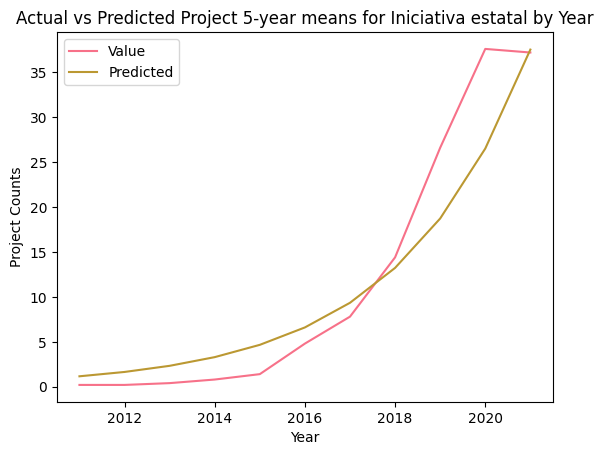

In [54]:
#We plot some predictions to see how the model is performing

# Set 'Year' as the index
df_mean_expanded.set_index('Year', inplace=True)

# Plot actual vs predicted project counts
df_mean_expanded[df_mean_expanded['Category']=='Digital'][['Value','Predicted']].plot()
plt.title('Actual vs Predicted Project 5-year means for Iniciativa estatal by Year')
plt.xlabel('Year')
plt.ylabel('Project Counts')

plt.show()

In [55]:
#Get rmse for each prediction
for column in df_num_proyectos.columns:
    actual = df_mean_expanded[df_mean_expanded['Category']==column]['Value']
    predicted = df_mean_expanded[df_mean_expanded['Category']==column]['Predicted']
    rmse = sqrt(mean_squared_error(actual, predicted))
    print(f'RMSE for {column}: {rmse}')

RMSE for Digital: 4.428651046212129
RMSE for NonDigital: 5.350857056155977


The RMSE are lower than the naïve model, which is a good sign. Finally, we predict data until 2028 to get an idea how the fitted model behaves in the future.

In [56]:
df_future = pd.DataFrame(columns=['Year', 'Category'])
for year in range(2019,2028):
    for column in df_num_proyectos.columns[:4]:
        df_future.loc[len(df_future)] = [year, column]

df_future['Predicted'] = nbinomial_glm.predict(df_future)
df_future.set_index('Year', inplace=True)

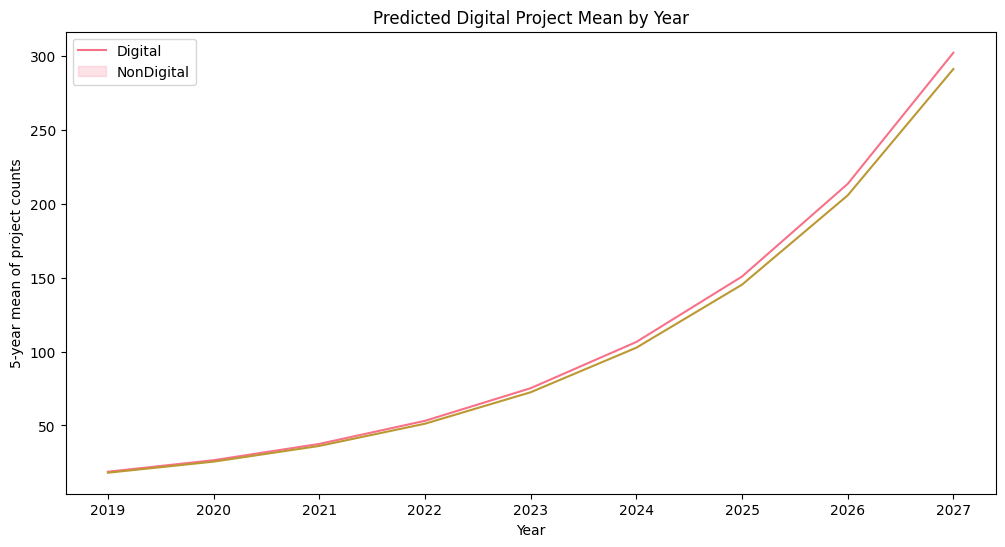

In [58]:
# Set the color palette to 'husl'
sns.set_palette('husl')
fig = plt.figure(figsize=(12, 6))

# Plot the future predictions for Category Digital
sns.lineplot(x=df_future[df_future['Category']=='Digital'].index, y='Predicted', data=df_future[df_future['Category']=='Digital'])
# sns.lineplot(x=df_mean_5.index, y='Digital', data=df_mean_5, label='Digital')
sns.lineplot(x=df_future[df_future['Category']=='NonDigital'].index, y='Predicted', data=df_future[df_future['Category']=='NonDigital'])
# sns.lineplot(x=df_mean_5.index, y='NonDigital', data=df_mean_5, label='NonDigital')

plt.title('Predicted Digital Project Mean by Year')
plt.xlabel('Year')
plt.ylabel('5-year mean of project counts')
plt.legend(['Digital',  'NonDigital'])
# plt.savefig('../plots/predicted_digital_project_mean_by_year.png', dpi=300, bbox_inches='tight')
plt.show()